In [5]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from src.data_handling import load_csv_data
from src.black_scholes import annualized_volatility, black_scholes

FILE_PATH = "DATA/processed/simulated_data.csv"

def straddle(S, K, T, r, sigma):
    call = black_scholes(S, K, T, r, sigma, option_type = 'call')
    put  = black_scholes(S, K, T, r, sigma, option_type = 'put')

    return call+put

In [6]:
simulated_df = load_csv_data(FILE_PATH)
simulated_df = simulated_df.sort_index(axis=1)
simulated_df.head()

,AAPL_Close,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,AMZN_Close,AMZN_High,AMZN_Low,AMZN_Open,AMZN_Volume,...,SPX_Close,SPX_High,SPX_Low,SPX_Open,SPX_Volume,VIX_Close,VIX_High,VIX_Low,VIX_Open,Year
1970-01-01 00:00:00.000000000,27.332500,27.681031,27.077343,27.077343,1.344724e+08,15.426000,16.264501,15.134788,16.264501,7.574200e+07,...,2027.781148,2063.066945,2015.570797,2059.619561,3.434120e+09,17.790001,18.408288,15.828744,17.935750,2015
1970-01-01 00:00:00.000000001,26.557177,26.557177,24.953013,25.237466,2.430464e+08,15.652773,16.086656,14.695559,15.663200,5.387000e+07,...,2030.294935,2030.790126,2011.179752,2011.179752,3.446810e+09,17.785684,17.839100,17.299911,17.299911,2015
1970-01-01 00:00:00.000000002,26.687879,27.206540,26.687879,26.704721,1.210756e+08,15.504552,16.326019,15.092613,15.092613,5.620000e+07,...,2032.379961,2033.434938,2024.973878,2024.973878,3.434120e+09,17.794727,18.858411,16.897036,18.858411,2015
1970-01-01 00:00:00.000000003,26.825670,26.825670,25.783558,25.783558,1.266652e+08,15.225908,15.268748,14.565987,14.565987,7.527200e+07,...,2030.255268,2046.277728,1971.954337,2026.018734,3.092080e+09,17.792826,18.297265,17.792826,18.297265,2015
1970-01-01 00:00:00.000000004,26.683030,28.007661,26.169826,26.169826,2.040924e+08,15.112950,16.186109,14.847606,16.186109,1.054620e+08,...,2031.678885,2046.239905,2024.954109,2025.448071,3.199465e+09,17.779676,18.673024,12.895266,12.895266,2015


In [7]:
X_DAYS_PRIOR    = 7
Y_DAYS_FORECAST = 7
TT_RATIO = 0.8
# List comprehensions to collect data
y_train, x_train = [], []
y_test, x_test   = [], []

# Group by 'Year' and 'N_Sim' and apply a rolling window
groups = simulated_df.groupby(["Year", "N_Sim"])

for (year, n_sim), group_df in groups:
    rolling_samples = group_df.rolling(X_DAYS_PRIOR + Y_DAYS_FORECAST)
    
    valid_samples = [sample for sample in rolling_samples if sample.shape[0] == X_DAYS_PRIOR + Y_DAYS_FORECAST]

    y_train.extend([sample["SPX_Close"].iloc[X_DAYS_PRIOR:].values for sample in valid_samples])
    x_train.extend([sample.drop(columns=["Year", "N_Sim"])[:X_DAYS_PRIOR].values for sample in valid_samples])


x_train, x_test = np.array(x_train), np.array(x_test)
y_train, y_test = np.array(y_train), np.array(y_test)

In [8]:
 # labelling data if 2*std < Black scholes price
def label_BS_std(x, y):
    y_2std = np.array([y_i.std()*3 for y_i in y])

    x_vol  = [annualized_volatility(i[:, 19]) for i in x]
    x_straddle_price = [straddle(x[i][-1, 19], x[i][-1, 19], 7/252, x[i][-1,10], x_vol[i]) for i in range(len(x))]

    y_bin  = y_2std < np.array(x_straddle_price)
    y_bin  = [int(i) for i in y_bin]

    return np.array(x), np.array(y_bin)


# labelling data based on actual profitability, if y[-1] < black scholes price
def label_BS_prof(x, y): 
    last_price_x = np.array([x_i[-1, 19] for x_i in x])
    last_price_y = np.array([y_i[-1] for y_i in y])
    x_vol  = [annualized_volatility(x_i[:, 19]) for x_i in x]
    x_irx  = [x_i[-1, 10] for x_i in x]

    x_straddle_prices = [straddle(last_price_x[i], last_price_x[i], 7/252, x_irx[i], x_vol[i]) for i in range(len(x))]

    # change in price
    diff = abs(last_price_x - last_price_y)

    # Check if it is within break-even straddle price
    y_bin  = diff < np.array(x_straddle_prices)
    y_bin  = [int(i) for i in y_bin]

    return np.array(x), np.array(y_bin)

TT_INDEX = int(TT_RATIO * len(x_train))

x_test, y_lab_test = label_BS_prof(x_train[TT_INDEX:], y_train[TT_INDEX:])
x_train, y_lab_train = label_BS_prof(x_train[:TT_INDEX], y_train[:TT_INDEX])



In [9]:
print(f"Train Prob: {sum(y_lab_train)/len(y_lab_train)}")
print(f"test Prob: {sum(y_lab_test)/len(y_lab_test)}")

print(f"X_train shape : {x_train.shape}")
print(f"Y_train shape : {y_lab_train.shape}")
print(f"X_test shape : {x_test.shape}")
print(f"Y_test shape : {y_lab_test.shape}")

Train Prob: 0.8318572874493927
test Prob: 0.4984817813765182
X_train shape : (7904, 7, 28)
Y_train shape : (7904,)
X_test shape : (1976, 7, 28)
Y_test shape : (1976,)


In [10]:
# k-fold
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, val_index in kf.split(x_train):

    x_train_new, x_val = x_train[train_index], x_train[val_index]
    # print(y_train[train_index])
    y_train_new, y_val = y_lab_train[train_index], y_lab_train[val_index]


<h3> Attention Model </h3>

<h4> Adaptive scaling </h4>

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, MultiHeadAttention
from tensorflow.keras.models import Model
from src.Dain_Gateless import Dain_Gateless
import keras
class AdaptiveScaling(Layer):
    def __init__(self, **kwargs):
        super(AdaptiveScaling, self).__init__(**kwargs)

    def build(self, input_shape):
        self.alpha = self.add_weight(name='alpha', 
                                     shape=(1, input_shape[-1]),
                                     initializer='ones',
                                     trainable=True)
        self.beta = self.add_weight(name='beta', 
                                    shape=(1, input_shape[-1]),
                                    initializer='zeros',
                                    trainable=True)
        super(AdaptiveScaling, self).build(input_shape)

    def call(self, x):
        return self.alpha * x + self.beta

num_heads = 8  # Adjust as needed

# Model architecture
inputs = Input(shape=x_train[0].shape)

# Adaptive Scaling
scaled_inputs = Dain_Gateless()(inputs)

# First Multi-Head Attention Layer
attention_out1 = MultiHeadAttention(num_heads=num_heads, key_dim=26)(scaled_inputs, scaled_inputs)

# Flatten and feed to a Dense layer
flattened_out = Flatten()(attention_out1)
dense_out = Dense(50, activation='relu')(flattened_out)

# Final output layer
output = Dense(1, activation='sigmoid')(dense_out)

model = Model(inputs=[inputs], outputs=output)
adam = keras.optimizers.Adam(lr=0.00000001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 28)]      0           []                               
                                                                                                  
 dain_gateless (Dain_Gateless)  (None, 7, 28)        2           ['input_1[0][0]']                
                                                                                                  
 multi_head_attention (MultiHea  (None, 7, 28)       23948       ['dain_gateless[0][0]',          
 dAttention)                                                      'dain_gateless[0][0]']          
                                                                                                  
 flatten (Flatten)              (None, 196)          0           ['multi_head_attention[0][0]'

c:\Users\bruce\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
hist = model.fit(x_train_new, y_train_new, validation_data=(x_val, y_val), epochs = 40, batch_size=256)

Epoch 1/40
28/28 [==============================] - 1s 17ms/step - loss: 0.6092 - accuracy: 0.8292 - auc: 0.4781 - val_loss: 0.6016 - val_accuracy: 0.8557 - val_auc: 0.4948
Epoch 2/40
28/28 [==============================] - 0s 12ms/step - loss: 0.6092 - accuracy: 0.8292 - auc: 0.4753 - val_loss: 0.6015 - val_accuracy: 0.8557 - val_auc: 0.5006
Epoch 3/40
28/28 [==============================] - 0s 11ms/step - loss: 0.6091 - accuracy: 0.8292 - auc: 0.4738 - val_loss: 0.6015 - val_accuracy: 0.8557 - val_auc: 0.5020
Epoch 4/40
28/28 [==============================] - 0s 11ms/step - loss: 0.6091 - accuracy: 0.8292 - auc: 0.4717 - val_loss: 0.6014 - val_accuracy: 0.8557 - val_auc: 0.5049
Epoch 5/40
28/28 [==============================] - 0s 12ms/step - loss: 0.6090 - accuracy: 0.8292 - auc: 0.4722 - val_loss: 0.6014 - val_accuracy: 0.8557 - val_auc: 0.5026
Epoch 6/40
28/28 [==============================] - 0s 12ms/step - loss: 0.6090 - accuracy: 0.8292 - auc: 0.4716 - val_loss: 0.6013 - v

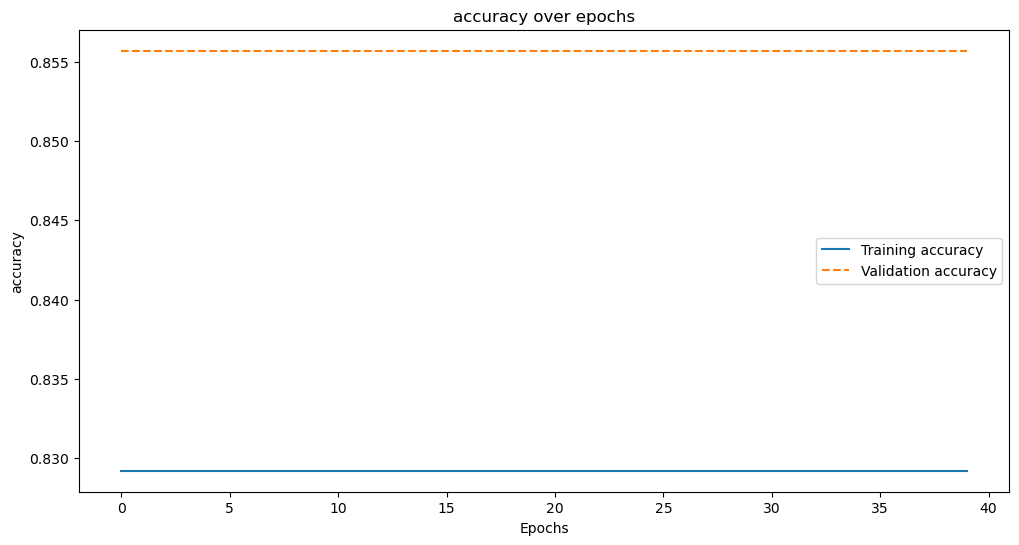

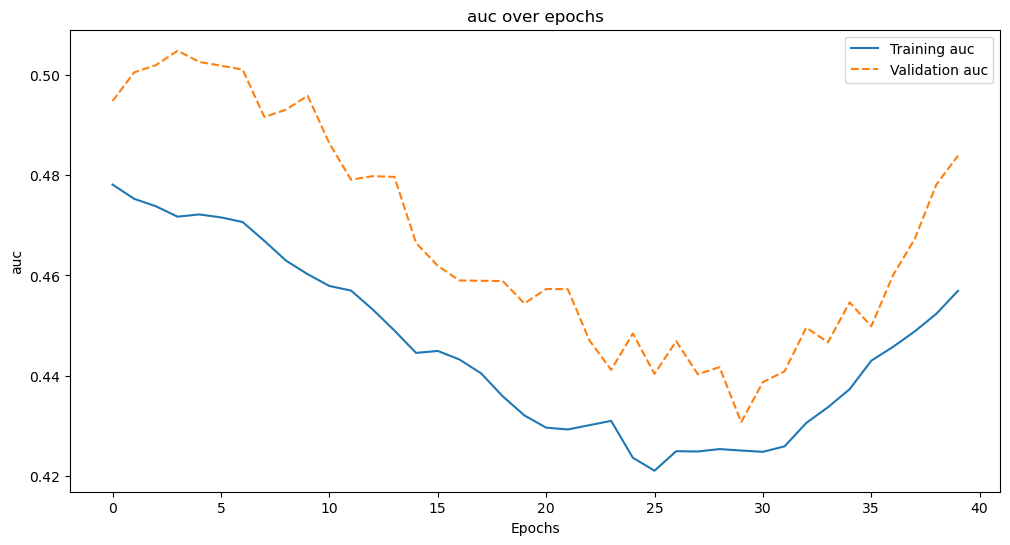

In [13]:
import matplotlib.pyplot as plt

def plot_error_metrics(history):
    metrics = ['accuracy','auc']
    
    for metric in metrics:
        # Plot metric
        plt.figure(figsize=(12, 6))
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}', linestyle='--')
        
        plt.title(f'{metric} over epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.show()

plot_error_metrics(hist)


In [14]:
pred = model.predict(x_test)

62/62 [==============================] - 0s 913us/step


In [15]:
import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_lab_test, pred)
metrics.auc(fpr, tpr)

0.5056395887863872

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, MultiHeadAttention
from tensorflow.keras.models import Model
from src.Dain_Gateless import Dain_Gateless
import keras
class AdaptiveScaling(Layer):
    def __init__(self, **kwargs):
        super(AdaptiveScaling, self).__init__(**kwargs)

    def build(self, input_shape):
        self.alpha = self.add_weight(name='alpha', 
                                     shape=(1, input_shape[-1]),
                                     initializer='ones',
                                     trainable=True)
        self.beta = self.add_weight(name='beta', 
                                    shape=(1, input_shape[-1]),
                                    initializer='zeros',
                                    trainable=True)
        super(AdaptiveScaling, self).build(input_shape)

    def call(self, x):
        return self.alpha * x + self.beta

num_heads = 8  # Adjust as needed

# Model architecture
inputs = Input(shape=x_train[0].shape)

# Adaptive Scaling
scaled_inputs = Dain_Gateless()(inputs)

# First Multi-Head Attention Layer
attention_out1 = MultiHeadAttention(num_heads=num_heads, key_dim=26)(scaled_inputs, scaled_inputs)

# Flatten and feed to a Dense layer
flattened_out = Flatten()(attention_out1)
dense_out = Dense(50, activation='relu')(flattened_out)

# Final output layer
output = Dense(1, activation=None)(dense_out)

model = Model(inputs=[inputs], outputs=output)
adam = keras.optimizers.Adam(lr=0.0000001)
model.compile(optimizer=adam, loss='mse', metrics=['mae'])

print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 7, 28)]      0           []                               
                                                                                                  
 dain_gateless (Dain_Gateless)  (None, 7, 28)        2           ['input_2[0][0]']                
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 7, 28)       23948       ['dain_gateless[0][0]',          
 eadAttention)                                                    'dain_gateless[0][0]']          
                                                                                                  
 flatten_1 (Flatten)            (None, 196)          0           ['multi_head_attention_1[0]

c:\Users\bruce\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
hist = model.fit(x_train, np.array(y_std_train), epochs = 40, batch_size=124)

Epoch 1/40
102/102 [==============================] - 5s 35ms/step - loss: 20.1929 - mae: 3.4201
Epoch 2/40
102/102 [==============================] - 4s 34ms/step - loss: 16.8385 - mae: 3.1379
Epoch 3/40
102/102 [==============================] - 3s 34ms/step - loss: 16.5886 - mae: 3.1108
Epoch 4/40
102/102 [==============================] - 3s 34ms/step - loss: 16.5616 - mae: 3.1031
Epoch 5/40
102/102 [==============================] - 4s 34ms/step - loss: 16.4447 - mae: 3.0897
Epoch 6/40
102/102 [==============================] - 4s 35ms/step - loss: 16.3111 - mae: 3.0735
Epoch 7/40
102/102 [==============================] - 3s 34ms/step - loss: 16.1685 - mae: 3.0573
Epoch 8/40
102/102 [==============================] - 4s 35ms/step - loss: 16.1566 - mae: 3.0620
Epoch 9/40
102/102 [==============================] - 4s 38ms/step - loss: 16.1304 - mae: 3.0533
Epoch 10/40
102/102 [==============================] - 4s 38ms/step - loss: 16.2270 - mae: 3.0631
Epoch 11/40
102/102 [========

In [ ]:
se = (pred.reshape(-1) - y_std_test) **2
mse = se.mean()

print(mse)

In [ ]:
abs(pred.reshape(-1) - y_std_test).mean()

In [ ]:
y_std_test